In [1]:
# This is to control wether we load trained model or train the model from scratch
LOAD_MODEL = False

In [2]:
import numpy as np
import pandas as pd
import os, datetime
!pip install yfinance
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tensorflow version: 2.8.2


In [3]:
def preprocessing(df):
  '''Calculate percentage change'''
  # df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
  # df['High'] = df['High'].pct_change() # Create arithmetic returns column
  # df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
  # df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
  # df['Volume'] = df['Volume'].pct_change()

  df = df.diff()
  df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
  ###############################################################################
  '''Create indexes to split dataset'''

  times = sorted(df.index.values)
  last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
  last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

  ###############################################################################
  '''Normalize price columns'''
  
  df = df.dropna()
  df = df[df!=np.inf]
  min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
  max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

  # Min-max normalize price columns (0-1 range)
  df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
  df['High'] = (df['High'] - min_return) / (max_return - min_return)
  df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
  df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

  ###############################################################################
  '''Normalize volume column'''
  df = df.dropna()
  df = df[df!=np.inf]
  min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
  max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

  # Min-max normalize volume columns (0-1 range)
  df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

  ###############################################################################
  '''Create training, validation and test split'''

  df = df.dropna()
  df = df[df!=np.inf]
  df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
  df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
  df_test = df[(df.index >= last_10pct)]

  # Remove date column
  df_train.drop(columns=['Date'], inplace=True)
  df_val.drop(columns=['Date'], inplace=True)
  df_test.drop(columns=['Date'], inplace=True)

  # Convert pandas columns into arrays
  train_data = df_train.values
  val_data = df_val.values
  test_data = df_test.values

  print('Training data shape: {}'.format(train_data.shape))
  print('Validation data shape: {}'.format(val_data.shape))
  print('Test data shape: {}'.format(test_data.shape))
  return (train_data,val_data,test_data,(min_return,max_return))



In [4]:
def train_test_split(train_data,val_data,test_data):
  # Training data
  X_train, y_train = [], []
  for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
  X_train, y_train = np.array(X_train), np.array(y_train)
  
  ###############################################################################

  # Validation data
  X_val, y_val = [], []
  for i in range(seq_len, len(val_data)):
      X_val.append(val_data[i-seq_len:i])
      y_val.append(val_data[:, 3][i])
  X_val, y_val = np.array(X_val), np.array(y_val)

  ###############################################################################

  # Test data
  X_test, y_test = [], []
  for i in range(seq_len, len(test_data)):
      X_test.append(test_data[i-seq_len:i])
      y_test.append(test_data[:, 3][i])    
  X_test, y_test = np.array(X_test), np.array(y_test)
  print('Training set shape', X_train.shape, y_train.shape)
  print('Validation set shape', X_val.shape, y_val.shape)
  print('Testing set shape' ,X_test.shape, y_test.shape)
  return (X_train,y_train,X_val,y_val,X_test,y_test)

In [5]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [6]:
with open('/content/tickers.txt') as tfile:
  tickers = tfile.read()
tickers = tickers.split()

In [7]:
# combining different stocks to train, val, test set

data_history = []
first=True
for ticker in tqdm(np.random.choice(tickers,size=50, replace=False).tolist()+['AAPL','IBM','QQQ','NVDA','TSLA'],total=55):
  print(ticker)
  df = yf.download(ticker).reset_index()
  df = df.drop(columns='Close')
  df.columns=['Date','Open','High','Low','Close','Volume']
  if len(df.index)==0:
    print("Cannot featch the data! Ticker not found.")
    continue
  if len(df.index)<=seq_len*10:
    print("Stock Data Not Big Enough!")
    continue
    
  train_data,val_data,test_data,min_max = preprocessing(df)
  data_history.append((ticker,min_max,(len(train_data),len(val_data),len(test_data))))
  X_train,y_train,X_val,y_val,X_test,y_test = train_test_split(train_data,val_data,test_data)

  if first:
    X_train_all,y_train_all,X_val_all,y_val_all,X_test_all,y_test_all = X_train,y_train,X_val,y_val,X_test,y_test
    first=False
    continue

  X_train_all,y_train_all,X_val_all,y_val_all,X_test_all,y_test_all\
        = np.vstack((X_train_all,X_train)), np.concatenate((y_train_all,y_train)),\
          np.vstack((X_val_all,X_val)), np.concatenate((y_val_all,y_val)),\
          np.vstack((X_test_all,X_test)), np.concatenate((y_test_all,y_test)),

  0%|          | 0/55 [00:00<?, ?it/s]

TWN
[*********************100%***********************]  1 of 1 completed
Training data shape: (7167, 5)
Validation data shape: (896, 5)
Test data shape: (895, 5)
Training set shape (7039, 128, 5) (7039,)
Validation set shape (768, 128, 5) (768,)
Testing set shape (767, 128, 5) (767,)
BNED
[*********************100%***********************]  1 of 1 completed
Training data shape: (1400, 5)
Validation data shape: (175, 5)
Test data shape: (174, 5)
Training set shape (1272, 128, 5) (1272,)
Validation set shape (47, 128, 5) (47,)
Testing set shape (46, 128, 5) (46,)
PCK
[*********************100%***********************]  1 of 1 completed
Training data shape: (4032, 5)
Validation data shape: (504, 5)
Test data shape: (504, 5)
Training set shape (3904, 128, 5) (3904,)
Validation set shape (376, 128, 5) (376,)
Testing set shape (376, 128, 5) (376,)
DOC
[*********************100%***********************]  1 of 1 completed
Training data shape: (1804, 5)
Validation data shape: (226, 5)
Test data sh

In [8]:
data_history

[('TWN', (-33.0, 37.375), (7167, 896, 895)),
 ('BNED', (-3.6100006103515625, 1.696000099182129), (1400, 175, 174)),
 ('PCK', (-2.1499996185302734, 1.7799997329711914), (4032, 504, 504)),
 ('DOC', (-3.4300003051757812, 2.0), (1804, 226, 225)),
 ('CSTM', (-4.309999465942383, 2.690000534057617), (1836, 229, 229)),
 ('GPC', (-4.349998474121094, 8.09876537322998), (8532, 1067, 1066)),
 ('KTF', (-1.809999942779541, 11.75), (6792, 849, 848)),
 ('HUN', (-7.880000114440918, 5.399999618530273), (3501, 438, 437)),
 ('CHMI', (-3.390000343322754, 2.0500001907348633), (1761, 220, 220)),
 ('MO', (-51.380001068115234, 6.125), (12184, 1523, 1523)),
 ('AX', (-10.717500686645508, 5.029998779296875), (3484, 436, 435)),
 ('HLF', (-8.685001373291016, 6.874998092651367), (3533, 442, 441)),
 ('HEP', (-2.9300003051757812, 2.990001678466797), (3624, 453, 452)),
 ('DLX', (-4.896938323974609, 26.383499145507812), (8532, 1067, 1066)),
 ('CTEK', (-11.610000610351562, 11.25), (4147, 518, 518)),
 ('FIF', (-2.21000003

In [9]:
X_train_all.shape,y_train_all.shape,X_val_all.shape,y_val_all.shape,X_test_all.shape,y_test_all.shape

((205759, 128, 5),
 (205759,),
 (21019, 128, 5),
 (21019,),
 (20995, 128, 5),
 (20995,))

In [10]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [11]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [12]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
  return model

In [13]:
gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=.80)
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
model = create_model()
model.summary()

NAME=f"StockTranformers{datetime.datetime.now().strftime('%m%d%y')}"

log_dir = f'./logs/{NAME}'
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 128, 2)       512         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 7)       0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 128, 7)      99114       ['concatenate[0][0]',        

In [14]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train_all, y_train_all, 32)
val_gen = DataGenerator(X_val_all, y_val_all, 32)

In [15]:
if not LOAD_MODEL:
  history = model.fit(train_gen,  
                      epochs=2, 
                      callbacks=[callback,tensorboard],
                      validation_data=val_gen)  

  model.save('stock_pred_transformers')

Epoch 1/2
6430/6430 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0356 - mse: 0.0030
Epoch 1: val_loss improved from inf to 0.00402, saving model to Transformer+TimeEmbedding.hdf5
6430/6430 [==============================] - 14972s 2s/step - loss: 0.0030 - mae: 0.0356 - mse: 0.0030 - val_loss: 0.0040 - val_mae: 0.0357 - val_mse: 0.0040
Epoch 2/2
6430/6430 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0263 - mse: 0.0014
Epoch 2: val_loss improved from 0.00402 to 0.00386, saving model to Transformer+TimeEmbedding.hdf5
6430/6430 [==============================] - 14719s 2s/step - loss: 0.0014 - mae: 0.0263 - mse: 0.0014 - val_loss: 0.0039 - val_mae: 0.0327 - val_mse: 0.0039


INFO:tensorflow:Assets written to: stock_pred_transformers/assets


INFO:tensorflow:Assets written to: stock_pred_transformers/assets


In [16]:
model = tf.keras.models.load_model('multistock_price_change.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

In [17]:
#Calculate predication for training, validation and test data
# train_pred = model.predict(X_train_all)
# val_pred = model.predict(X_val_all)
# test_pred = model.predict(X_test_all)

# #Print evaluation metrics for all datasets
# train_eval = model.evaluate(X_train_all, y_train_all, verbose=0)
# val_eval = model.evaluate(X_val_all, y_val_all, verbose=0)
# test_eval = model.evaluate(X_test_all, y_test_all, verbose=0)

# print(' ')
# print('Evaluation metrics')
# print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
# print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
# print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [18]:
def get_test_data(ticker='IBM'):
   df_ibm = yf.download(ticker).reset_index()
   df_ibm = df_ibm.drop(columns='Close')
   df_ibm.columns=['Date','Open','High','Low','Close','Volume']
   train_data,val_data,test_data,min_max = preprocessing(df_ibm)
   X_train,y_train,X_val,y_val,X_test,y_test = train_test_split(train_data,val_data,test_data)
   return (X_test,y_test,min_max)

In [19]:
my_X_test,my_y_test,my_min_max = get_test_data()

[*********************100%***********************]  1 of 1 completed
Training data shape: (12184, 5)
Validation data shape: (1523, 5)
Test data shape: (1523, 5)
Training set shape (12056, 128, 5) (12056,)
Validation set shape (1395, 128, 5) (1395,)
Testing set shape (1395, 128, 5) (1395,)


In [20]:
my_pred = model.predict(my_X_test)

In [21]:
def decode_from_norm(std_change,min_max):
  min, max = min_max
  return std_change*(max-min)+min

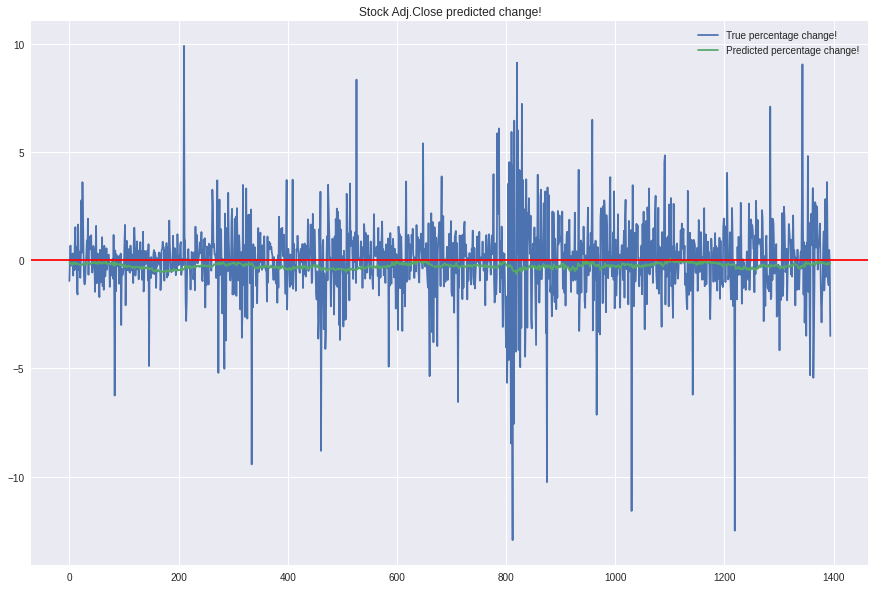

In [22]:
plt.figure(figsize=(15,10))
my_pred_dec = decode_from_norm(my_pred,my_min_max)
my_y_test_dec = decode_from_norm(my_y_test,my_min_max)
pd.Series(my_y_test_dec).plot(label="True percentage change!")
pd.Series(my_pred_dec.flatten()).plot(label="Predicted percentage change!")
plt.axhline(y=0,color='red')
plt.title("Stock Adj.Close predicted change!")
plt.legend()